In [1]:
# Let's import the needed packages

# To deal with arrays 
import xarray as xr
import pandas as pd 
pd.options.mode.chained_assignment = None
import numpy as np

# To plot curves
import matplotlib.pyplot as plt

# To plot the map
import cartopy.crs as ccrs

# Importing Models
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

# Prediction Scores
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Dimensionality reduction 
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

#import our useful functions 
import useful_functions

The goal of this notebook is to predict El Nino events with data from which we removed the seasonal cycle. The data that we use is created in the script preprocessing_temperature_data.ipynb.
 We do this to experiment whether the seasonal cycle is some noise that disturbs the prediction or if it is useful supplementary information that improves the prediction. 

# 1. One-month prediction

In [2]:
# Get the data for a 1-month prediction, split and scale the data

X, y = useful_functions.get_data("data/preprocessed_data/nino_dataset_1m_seasonal.npz")
X_train, X_test, y_train, y_test= useful_functions.split_scale_data(X, y, RANDOM_SPLIT = False, train_size = 374)

==== GET THE DATA ====
Shape of X: (474, 64800)
Shape of y: (474,)
First 25 elements of y: [0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
==== SPLIT & SCALE THE DATA ====
Shape of X_train: (374, 64800)
Shape of y_train: (374,)
Shape of X_test: (100, 64800)
Shape of y_test: (100,)


The problem here is that we have a small amount of data and the data are in high dimension. 
**=> High risk of overfitting**

Let us try to first simple model so we can have a baseline.

## 1. Baseline n°1 - LDA

### 1.1 First evaluation

In [3]:
# Define the classifier
lda = LinearDiscriminantAnalysis()

# Fit the model on the data
lda.fit(X_train,y_train)

# Get the prediction
y_test_pred_lda = lda.predict(X_test)
y_train_pred_lda = lda.predict(X_train)

# Computation of the AUC and accuracy
roc_auc_score_lda_test = roc_auc_score(y_test, lda.predict_proba(X_test)[:, 1])
accuracy_score_lda_test = accuracy_score(y_test, y_test_pred_lda)
roc_auc_score_lda_train = roc_auc_score(y_train, lda.predict_proba(X_train)[:, 1])
accuracy_score_lda_train = accuracy_score(y_train, y_train_pred_lda)

# Print the results
print("==== TRAIN ====")
print(f"Accuracy for TRAIN data: {accuracy_score_lda_train:.3f}")
print(f"     AUC for TRAIN data: {roc_auc_score_lda_train:.3f}")
print("==== TEST ====")
print(f"Accuracy for TEST data: {accuracy_score_lda_test:.3f}")
print(f"     AUC for TEST data: {roc_auc_score_lda_test:.3f}")


==== TRAIN ====
Accuracy for TRAIN data: 0.976
     AUC for TRAIN data: 0.998
==== TEST ====
Accuracy for TEST data: 0.610
     AUC for TEST data: 0.628


Overfitting !!!
Before trying this model, we will try to reduce the overfitting by performing dimensionality reduction.

### 1.2 Dimensionality reduction: PCA

Text(0.5, 1.0, 'Cumulative Explained Variance by Principal Components')

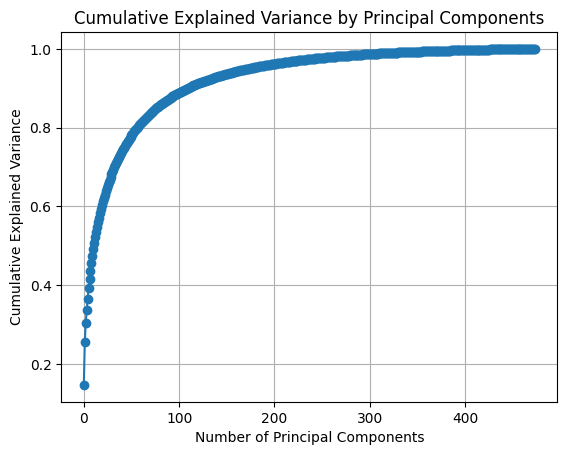

In [4]:
# PCA
PCA_sst = PCA(n_components = None)
PCA_sst.fit(X)

# Computation of the explained variance ratio
explained_variance_ratio_sst = PCA_sst.explained_variance_ratio_

# Plot of the explained variance ratio
plt.grid()
plt.plot(np.cumsum(explained_variance_ratio_sst), marker = 'o')

plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by Principal Components')

In [5]:
# Perform several LDA with different value of p to get a validation curve for this parameter
p_values = np.linspace(1, 100, 100).astype(int)
p_values = p_values.astype(int)
test_score_accuracy = []
train_score_accuracy = []

for p in p_values:
    # PCA with p principal components
    PCA_sst = PCA(n_components=p)
    PCA_sst.fit(X)

    # Project data
    Xp_sst = PCA_sst.transform(X)
    X_train, X_test, y_train, y_test = useful_functions.split_scale_data(Xp_sst, y, RANDOM_SPLIT = False, train_size = 374, verbose = False)

    # Define the classifier
    lda = LinearDiscriminantAnalysis()

    # Fit the model on the data
    lda.fit(X_train,y_train)

    # Get the prediction
    y_test_pred_lda = lda.predict(X_test)
    y_train_pred_lda = lda.predict(X_train)

    # Computation of the accuracy
    test_score_accuracy.append(accuracy_score(y_test, y_test_pred_lda))
    train_score_accuracy.append(accuracy_score(y_train, y_train_pred_lda))


In [6]:
# Get the best score
best_index = np.argsort(-np.array(test_score_accuracy))[0]
best_p_value = p_values[best_index]
best_test_score_pca = test_score_accuracy[best_index]
best_train_score_pca = train_score_accuracy[best_index]

# Prints
print(f"Best value of p - PCA : {best_p_value}")
print(f"Train Score for the best p: {best_train_score_pca}")
print(f"Test Score for the best p: {best_test_score_pca}")
print(f"Amélioration tu score de test: + {best_test_score_pca - accuracy_score_lda_test:.2f}")

Best value of p - PCA : 62
Train Score for the best p: 0.8582887700534759
Test Score for the best p: 0.84
Amélioration tu score de test: + 0.23


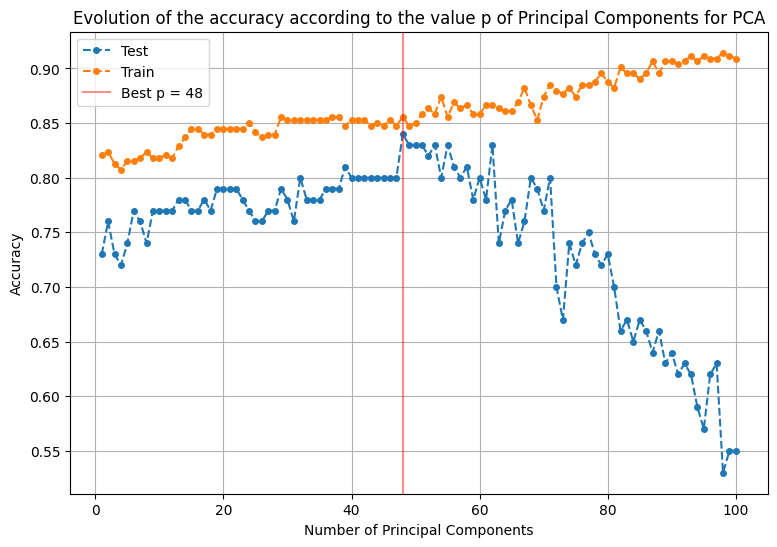

In [7]:
# Plot the validation curve
plt.figure(figsize=(9,6))
plt.plot(p_values, test_score_accuracy, 'o', markersize=4, ls='--', label="Test")
plt.plot(p_values, train_score_accuracy, 'o', markersize=4, ls='--', label="Train")
plt.axvline(x = best_p_value, color = 'red', linestyle = '-', label = f'Best p = {best_p_value}', alpha = 0.45)
plt.title("Evolution of the accuracy according to the value p of Principal Components for PCA")
plt.xlabel("Number of Principal Components")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()

Test accuracy with the best p: 0.81
Test auc with the best p: 0.85


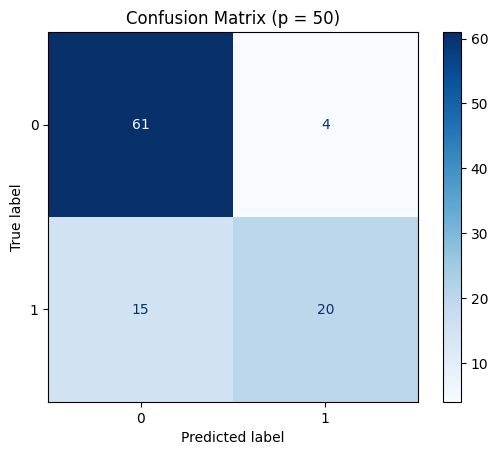

In [ ]:
# PCA with the best value of p
PCA_sst = PCA(n_components = best_p_value)
PCA_sst.fit(X)

Xp_sst = PCA_sst.transform(X)
X_train, X_test, y_train, y_test = useful_functions.split_scale_data(
    Xp_sst, y, RANDOM_SPLIT = False, train_size = 374, verbose = False
)

# Make predictions 
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)

y_test_pred_lda = lda.predict(X_test)
y_train_pred_lda = lda.predict(X_train)

# Print the scores
train_accuracy = accuracy_score(y_train, y_train_pred_lda)
roc_auc_score_lda_train = roc_auc_score(y_train, lda.predict_proba(X_train)[:, 1])
print(f"Train accuracy with the best p: {train_accuracy:.2f}")
print(f"Train AUC with the best p: {roc_auc_score_lda_train:.2f}")

test_accuracy = accuracy_score(y_test, y_test_pred_lda)
roc_auc_score_lda_test = roc_auc_score(y_test, lda.predict_proba(X_test)[:, 1])
print(f"Test accuracy with the best p: {test_accuracy:.2f}")
print(f"Test auc with the best p: {roc_auc_score_lda_test:.2f}")

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred_lda)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=lda.classes_)
disp.plot(cmap='Blues')
plt.title(f"Confusion Matrix (p = {best_p_value})")
plt.show()

## 2. Linear Regression, Ridge and Lasso

In [ ]:
# We work with the orinial data and split it 
X_train, X_test, y_train, y_test = useful_functions.split_scale_data(X, y, RANDOM_SPLIT = False, train_size = 374, verbose = False)
X_train, X_validation, y_train, y_validation = useful_functions.split_scale_data(X_train, y_train, RANDOM_SPLIT = False, train_size = 300, verbose = False)

In [ ]:
# Define the classifier
ridge = RidgeClassifier(alpha = 1.0) # Default hyperparameter

# Fit
ridge.fit(X_train, y_train)

# Predict
y_train_pred_ridge = ridge.predict(X_train)
y_test_pred_ridge = ridge.predict(X_test)

# Print the results
print("==== TRAIN ====")
print(f"Accuracy for TRAIN data: {ridge.score(X_train, y_train):.3f}")
print("==== TEST ====")
print(f"Accuracy for TEST data: {ridge.score(X_test, y_test):.3f}")

In [ ]:
# Prepare the lambda values
lambda_values = np.logspace(1, 7, 100)

# Initialisation of the lists that will contain the accuracies and the coefficients
accuracy_train_list = []
accuracy_valid_list = []
coefficients = []

for i in range(len(lambda_values)):
    # Define the classifier
    ridge = RidgeClassifier(alpha = lambda_values[i])

    # Fit
    ridge.fit(X_train, y_train)
    
    # Add the accuracy for train and validation to the lists
    accuracy_train_list.append(ridge.score(X_train, y_train))
    accuracy_valid_list.append(ridge.score(X_validation, y_validation))
    
    # Store the coefficients
    coefficients.append(ridge.coef_)
    
coefficients = np.array(coefficients)

# Find the lambda parameter that maximises the validation accuracy
max_accuracy_index = np.argmax(accuracy_valid_list)
max_lambda = lambda_values[max_accuracy_index]
max_accuracy = accuracy_valid_list[max_accuracy_index]
best_train_accuracy = accuracy_train_list[max_accuracy_index]

print(f"Best lambda value after validation: {max_lambda:.1f}")
print(f"Accuracy for training: {best_train_accuracy:.3f}")
print(f"Accuracy for validation: {max_accuracy:.3f}")

In [ ]:
# Plot the results
plt.figure(figsize=[8,8])
plt.subplot(2,1,1)

plt.semilogx(lambda_values, accuracy_train_list, label = "Accuracy for training data")
plt.semilogx(lambda_values, accuracy_valid_list, label = "Accuracy for validation data")
plt.axvline(x=max_lambda, color='r', linestyle='-', label=f'Max λ (Validation): {max_lambda:.2e}', alpha = 0.45)
plt.legend()
plt.xlabel('λ')
plt.ylabel('Accuracy')
plt.title('Ridge classification - Evolution of the Accuracy on training and validation data as a function of λ')
plt.grid()

plt.subplot(2,1,2)
plt.semilogx(lambda_values, coefficients[:, 0])
plt.xlabel('λ')
plt.ylabel('Coefficient Values')
plt.grid()
plt.title('Ridge classification - Evolution of the coefficients as a function of λ')

plt.tight_layout() 

In [ ]:
# Evaluate the Best Ridge Model 
ridge = RidgeClassifier(alpha = max_lambda)
ridge.fit(X_train, y_train)

y_test_pred_ridge = ridge.predict(X_test)
y_train_pred_ridge = ridge.predict(X_train)

train_decision_values = ridge.decision_function(X_train)
test_decision_values = ridge.decision_function(X_test)

# Compute the scores 
train_accuracy = accuracy_score(y_train, y_train_pred_ridge)
roc_auc_score_train = roc_auc_score(y_train, train_decision_values)
print(f"Train accuracy with the best λ: {train_accuracy:.2f}")
print(f"Train AUC with the best λ: {roc_auc_score_train:.2f}")

test_accuracy = accuracy_score(y_test, y_test_pred_ridge)
roc_auc_score_test = roc_auc_score(y_test, test_decision_values)
print(f"Test accuracy with the best λ: {test_accuracy:.2f}")
print(f"Test auc with the best λ: {roc_auc_score_test:.2f}")

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred_ridge)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=ridge.classes_)
disp.plot(cmap='Blues')
plt.title(f"Confusion Matrix - Ridge (lamda = {max_lambda:.1f})")
plt.show()